# SLR TWSA Generation

We compare our predictions with the gravity fields with University of Bonn's [IGG-SLR-HYBRID](https://www.igg.uni-bonn.de/apmg/de/data-and-models/igg-slr-hybrid)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shxarray  # noqa
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats
from pandas.tseries.offsets import MonthBegin

import deeprec  # noqa
import deeprec.preprocessing.preprocessors as pp
from deeprec.utils import ROOT_DIR

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
set_matplotlib_formats("retina")
# sns.set_style("ticks")
plt.style.use(ROOT_DIR / "config/style_notebook.mplstyle")

# Register dask progress bar
ProgressBar(minimum=5).register()

In [14]:
# Open targets for later reference
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)

mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()

csr_grid = tgts.twsa_csr

# Apply mask
csr_grid = csr_grid.where(mask == 1)
csr_grid

<xarray.DataArray 'twsa_csr' (time: 210, lat: 360, lon: 720)> Size: 218MB
dask.array<where, shape=(210, 360, 720), dtype=float32, chunksize=(210, 360, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 2kB 2002-04-01 2002-08-01 ... 2023-09-01
Attributes:
    long_name:      Terrestrial Water Storage Anomaly
    standard_name:  twsa
    units:          mm

In [15]:
in_dir = (
    ROOT_DIR
    / "data/raw/targets/igg-slr-hybrid/10.22000-357"
    / "data/dataset/IGG-SLR-HYBRID_EnsMean"
)
# Generator containing all monthly solutions
in_files = in_dir.glob("*.gfc")

In [16]:
out_dir = ROOT_DIR / "data/processed/igg-slr-hybrid"
out_dir.mkdir(parents=True, exist_ok=True)
out_file = out_dir / "igg-slr-hybrid_1992-2020.nc"

## Covert spherical harmonics to gridded TWSA with `shxarray`

In [17]:
cnm_list = []

for filename in in_files:
    cnm = xr.open_dataset(str(filename), engine="icgem")
    cnm_list.append(cnm)

da_cnm = xr.concat(cnm_list, "time").cnm

c:\Users\luisg\Repositories\deep-waters\.venv\Lib\site-packages\shxarray\io\icgem.py:148: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'nm' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds=xr.Dataset(data_vars=dict(cnm=(shp,cnm,get_cfatts("stokes")),sigcnm=(shp,sigcnm,get_cfatts("stokes stdv"))),coords=coords,attrs=attr)
c:\Users\luisg\Repositories\deep-waters\.venv\Lib\site-packages\shxarray\io\icgem.py:148: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'nm' coordinate(s) or data variab

In [52]:
# Calculate TWS
ds_tws = da_cnm.isel(nm=slice(1, None)).sh.tws().to_dataset(name="twsa_slr")

# Apply filters
ds_tws["twsa_slr_gauss"] = ds_tws.twsa_slr.sh.filter("Gauss", halfwidth=300)

# Transform to 0.5° × 0.5° grid
ds_tws_grid = ds_tws.sh.synthesis(lon=csr_grid.lon, lat=csr_grid.lat).sortby("time")

# Calculate anomaly
baseline = slice("2004", "2009")
mean = ds_tws_grid.sel(time=baseline).mean("time")
ds_twsa_grid = ds_tws_grid - mean

# Convert to mm
ds_twsa_grid = ds_twsa_grid * 1000

shxarray-INFO: C:\Users\luisg/.cache/shxarray_storage\Love\geoslurp_dump_llove.sql already exists, no need to download)


In [ ]:
# Adjust time to the first of the month
ds_twsa_grid["time"] = (
    pd.to_datetime(ds_twsa_grid.time) + MonthBegin() - MonthBegin(normalize=True)
)
# Reorder dimensions
dims = ("time", "lat", "lon", ...)
ds_twsa_grid = ds_twsa_grid.transpose(*dims)
# Set attributes (use the one from CSR)
ds_twsa_grid = pp.set_dim_attrs(ds_twsa_grid)

In [55]:
# Write to file
WRITE = True

ZARR_STORE = ROOT_DIR / "data/processed/igg-slr-hybrid.zarr"

if WRITE:
    ds_twsa_grid.chunk(time=-1, lat=120, lon=120).astype(np.float32).to_zarr(
        ZARR_STORE, mode="w"
    )
else:
    ds_twsa_grid = xr.open_zarr(ZARR_STORE)

In [56]:
# Merge with GRACE
ds_twsa_grid["twsa_csr"] = csr_grid.compute()

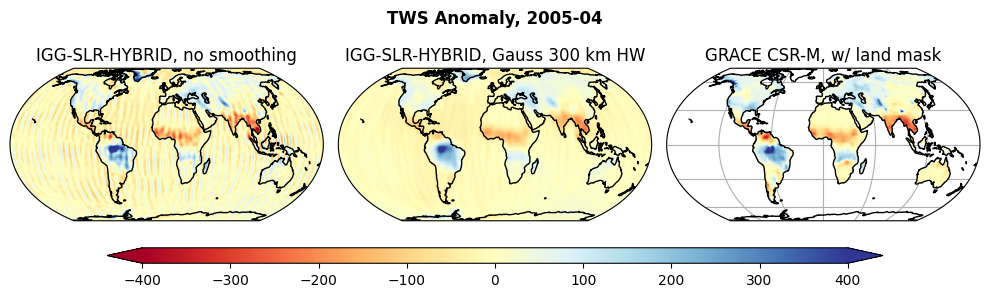

In [95]:
# Plot results
TIME = "2005-04"
plot_kwargs = dict(vmin=-400, coastlines=True, gridlines=True)
p = (
    ds_twsa_grid.sel(time=TIME)
    .to_dataarray()
    .dr.projplot(col="variable", **plot_kwargs)
)
p.fig.suptitle(f"TWS Anomaly, {TIME}", weight="bold")
axs = p.axs.flatten()
axs[0].set_title("IGG-SLR-HYBRID, no smoothing")
axs[1].set_title("IGG-SLR-HYBRID, Gauss 300 km HW")
axs[2].set_title("GRACE CSR-M, w/ land mask");

Plot a river basin:

Text(0.5, 0.98, 'TWS Anomaly, Congo Basin')

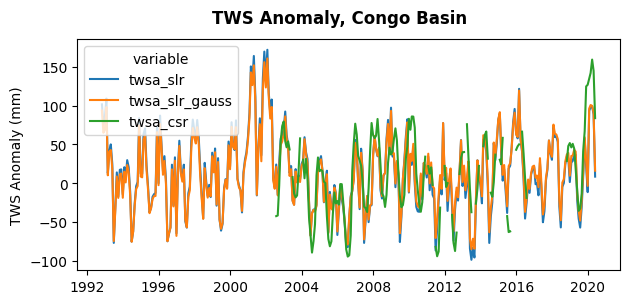

In [58]:
ds_twsa_congo = (
    ds_twsa_grid.dr.select_basins("Congo", return_region=False)
    .dr.weight_lat()
    .mean(["lat", "lon"])
)

fig, ax = plt.subplots(figsize=(7, 3))
ds_twsa_congo.to_dataarray().plot(hue="variable", ax=ax)
ax.set(ylabel="TWS Anomaly (mm)", xlabel=None)
fig.suptitle("TWS Anomaly, Congo Basin", weight="bold")

## New SLR product (from Lara)

In [77]:
slr2 = xr.open_dataset(
    ROOT_DIR
    / "data/raw/targets/igg-slr-hybrid-2"
    / "IGG_SLR_Hybrid_A_EWH_Land_1995-2015.nc"
)
slr2


<xarray.Dataset> Size: 132MB
Dimensions:  (time: 252, longitude: 361, latitude: 181)
Dimensions without coordinates: time, longitude, latitude
Data variables:
    mjd      (time) float64 2kB ...
    lon      (longitude) float64 3kB ...
    lat      (latitude) float64 1kB ...
    ewh      (time, longitude, latitude) float64 132MB ...
Attributes:
    spatial resolution [deg]:  1
    temporal resolution:       monthly
    filter type:               DDK2

In [ ]:
# Clean Data
slr2 = slr2.rename(mjd="time", longitude="lon", latitude="lat")
# Convert from Modified Julian calendar
slr2.time.attrs = {"units": "days since 1858-11-17"}
slr2 = xr.decode_cf(slr2).assign_coords({"lat": slr2.lat, "lon": slr2.lon})
slr2["time"] = pd.to_datetime(slr2.time) + MonthBegin() - MonthBegin(normalize=True)
# Remove 360° lon (same as 0°)
slr2 = slr2.sel(lon=slice(1, None))
# Replace 0.0 in oceans with NaNs
all_zero = (slr2.ewh == 0.0).all(dim="time")
slr2 = slr2.where(~all_zero)

# Calc baseline
baseline = slice("2004", "2009")
slr2["ewh"] = slr2.ewh - slr2.ewh.sel(time=baseline).mean("time")
slr2 = slr2.rename(ewh="twsa_slr_2024")
slr2


<xarray.Dataset> Size: 131MB
Dimensions:        (time: 252, lon: 360, lat: 181)
Coordinates:
  * time           (time) datetime64[ns] 2kB 1995-01-01 ... 2015-12-01
  * lat            (lat) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * lon            (lon) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
Data variables:
    twsa_slr_2024  (time, lon, lat) float64 131MB nan nan nan ... nan nan nan
Attributes:
    spatial resolution [deg]:  1
    temporal resolution:       monthly
    filter type:               DDK2

In [ ]:
# Resort grid indices
slr2 = pp.clean_grid(slr2)
# Reorder dimensions
dims = ("time", "lat", "lon", ...)
slr2 = slr2.transpose(*dims)
# Set attributes (use the one from CSR)
slr2 = pp.set_dim_attrs(slr2)

Text(0.5, 0.98, 'TWS Anomaly, Congo Basin')

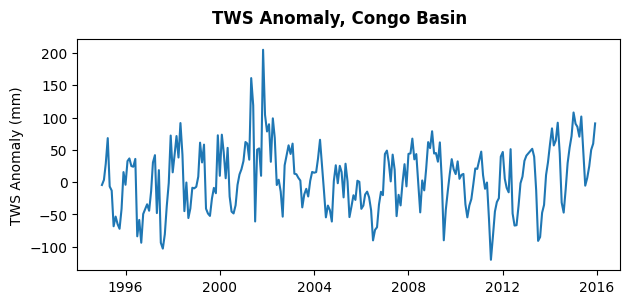

In [85]:
twsa_congo = (
    slr2.twsa_slr_2024.dr.select_basins("Congo", return_region=False)
    .dr.weight_lat()
    .mean(["lat", "lon"])
)

fig, ax = plt.subplots(figsize=(7, 3))
twsa_congo.plot(ax=ax)
ax.set(ylabel="TWS Anomaly (mm)", xlabel=None)
fig.suptitle("TWS Anomaly, Congo Basin", weight="bold")


In [86]:
# Write to file
WRITE = True

ZARR_STORE = ROOT_DIR / "data/processed/igg-slr-hybrid-2.zarr"

if WRITE:
    slr2.chunk(time=-1, lat=120, lon=120).astype(np.float32).to_zarr(
        ZARR_STORE, mode="w"
    )
else:
    slr2 = xr.open_zarr(ZARR_STORE)


In [88]:
import cartopy.crs as ccrs

In [ ]:
# Plot results
TIME = "2005-04"
p = (
    ds_twsa_grid.sel(time=TIME)
    .to_dataarray()
    .dr.projplot(
        col="variable",
    )
)
p.fig.suptitle(f"TWS Anomaly, {TIME}", weight="bold")
axs = p.axs.flatten()
axs[0].set_title("IGG-SLR-HYBRID, no smoothing")
axs[1].set_title("IGG-SLR-HYBRID, Gauss 300 km HW")
axs[2].set_title("GRACE CSR-M, w/ land mask");


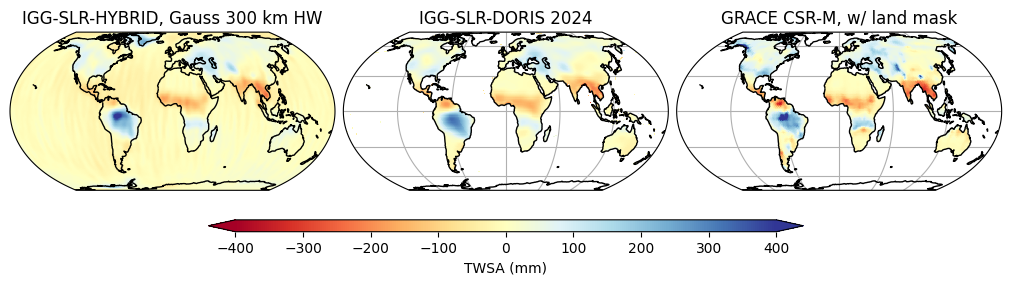

In [ ]:
# Compare 2021 and 2024 SLR products
plot_kwargs["add_colorbar"] = False
plot_kwargs["cbar_kwargs"] = None
fig, axs = plt.subplots(
    ncols=3,
    subplot_kw={"projection": ccrs.EqualEarth()},
    figsize=(10, 6),
    constrained_layout=True,
)
p = ds_twsa_grid.twsa_slr_gauss.sel(time=TIME).dr.projplot(ax=axs[0], **plot_kwargs)
slr2.twsa_slr_2024.sel(time=TIME).dr.projplot(ax=axs[1], **plot_kwargs)
csr_grid.sel(time=TIME).dr.projplot(ax=axs[2], **plot_kwargs)
axs[0].set_title("IGG-SLR-HYBRID, Gauss 300 km HW")
axs[1].set_title("IGG-SLR-DORIS 2024")
axs[2].set_title("GRACE CSR-M, w/ land mask")
plt.colorbar(
    p,
    ax=axs,
    location="bottom",
    label="TWSA (mm)",
    aspect=50,
    shrink=0.6,
    extend="both",
)
